# Imports and constants

In [48]:
import numpy as np
import matplotlib.pyplot as plt


R = 6371e3 # Earths mean radius [m] 
B_0 = 3.12e-5 # Earths mean magnetic field strength [T]
e = 1.602e-19 # Elementary charge [C]
m_p = 1.673e-27 # Proton mass [kg]
m_hat = np.array([np.sin(np.radians(11 + 23.5)), 0, np.cos(np.radians(11 + 23.5))]) # Dipole moment unit vector (tilted 34.5° from z-axis)


First we approximate the earths magnetic field to a dipole using spherical coordinates.

In [49]:
def get_B_field(pos): # The field will have azimuthal symmetry

    r_vec = np.array(pos)
    r = np.linalg.norm(pos)

    if r<R:
        return np.array([0,0,0])
    
    r_hat = r_vec/r

    B_vec = B_0 / (R/r)**3 * (3 * (np.dot(m_hat,r_hat))*r_hat-m_hat)

    return B_vec


# Plots

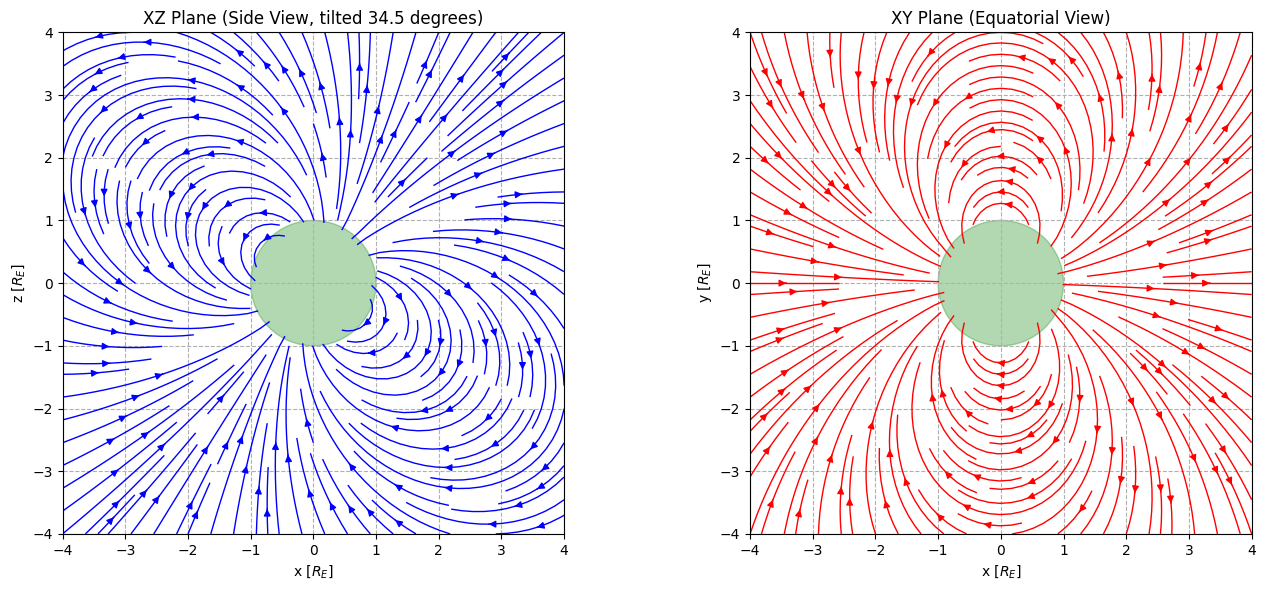

In [50]:
limit = 4 * R
points = 50
coords = np.linspace(-limit, limit, points)
X_grid, Z_grid = np.meshgrid(coords, coords)

Bx_xz = np.zeros_like(X_grid)
Bz_xz = np.zeros_like(Z_grid)

Bx_xy = np.zeros_like(X_grid)
By_xy = np.zeros_like(Z_grid)

# Calculate field at each point
for i in range(points):
    for j in range(points):
        b_xz = get_B_field(np.array([X_grid[i,j], 0, Z_grid[i,j]]))
        Bx_xz[i,j], Bz_xz[i,j] = b_xz[0], b_xz[2]
        
        b_xy = get_B_field(np.array([X_grid[i,j], Z_grid[i,j], 0]))
        Bx_xy[i,j], By_xy[i,j] = b_xy[0], b_xy[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# XZ Plane
ax1.streamplot(X_grid/R, Z_grid/R, Bx_xz, Bz_xz, color='blue', linewidth=1, density=1.5)
ax1.add_patch(plt.Circle((0, 0), 1, color='green', alpha=0.3, label='Earth'))
ax1.set_title("XZ Plane (Side View, tilted 34.5 degrees)")
ax1.set_xlabel("x [$R_E$]")
ax1.set_ylabel("z [$R_E$]")

# XY Plane 
ax2.streamplot(X_grid/R, Z_grid/R, Bx_xy, By_xy, color='red', linewidth=1, density=1.5)
ax2.add_patch(plt.Circle((0, 0), 1, color='green', alpha=0.3))
ax2.set_title("XY Plane (Equatorial View)")
ax2.set_xlabel("x [$R_E$]")
ax2.set_ylabel("y [$R_E$]")

for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

# Simulating the solar wind

In [51]:
def euler_solve_ivp(pos, v, dt):
    B = get_B_field(pos)
    a = e * np.cross(v, B) / m_p
    v_new = v + a * dt
    pos_new = pos + v_new * dt
    return pos_new, v_new

In [ ]:

# Initial Conditions
pos = np.array([10*R, 0, 0]) # Start further out, slightly offset from axis
v = np.array([-400_000, 0, 0])     # Moving TOWARD Earth (negative X)
dt = 0.005                         # Smaller dt for stability

trajectory = [pos.copy()]

# Safety: max_steps prevents infinite loops if the proton misses Earth
max_steps = 100000 
step = 0

while np.linalg.norm(pos) > R and step < max_steps:
    B = get_B_field(pos) 
    
    acceleration = (e / m_p) * np.cross(v, B)
    
    v = v + acceleration * dt
    
    pos = pos + v * dt
    
    trajectory.append(pos.copy())
    step += 1

trajectory = np.array(trajectory)

AttributeError: 'Axes3D' object has no attribute 'set_z_label'

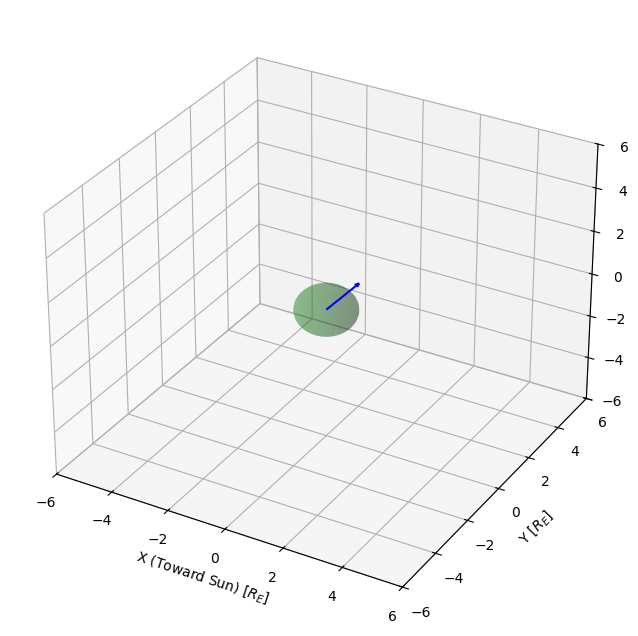

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_trajectory(trajectory, m_hat):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 1. Plot the Trajectory
    # trajectory is the (N, 3) numpy array from your loop
    ax.plot(trajectory[:, 0]/R, trajectory[:, 1]/R, trajectory[:, 2]/R, 
            label='Proton Path', color='red', linewidth=1)

    # 2. Draw Earth as a sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x_earth = np.outer(np.cos(u), np.sin(v))
    y_earth = np.outer(np.sin(u), np.sin(v))
    z_earth = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_earth, y_earth, z_earth, color='forestgreen', alpha=0.3)

    # 3. Draw the Magnetic Dipole Vector (m_hat)
    ax.quiver(0, 0, 0, m_hat[0]*2, m_hat[1]*2, m_hat[2]*2, 
              color='blue', label='Magnetic Axis', arrow_length_ratio=0.1)

    # Formatting
    limit = 6 # Radii to show
    ax.set_xlim([-limit, limit])
    ax.set_ylim([-limit, limit])
    ax.set_zlim([-limit, limit])
    ax.set_xlabel('X (Toward Sun) [$R_E$]')
    ax.set_ylabel('Y [$R_E$]')
    ax.set_z_label('Z (Ecliptic North) [$R_E$]')
    ax.set_title('Proton Trajectory in Earth\'s Magnetic Field')
    ax.legend()
    
    plt.show()

# Run the plot
plot_trajectory(trajectory, m_hat)